# Homework 2: CLIP zero-shot prediction
---
CLIP on two new scenarios.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import tqdm
from torchvision.datasets import CIFAR10
from torchvision import datasets
from torchvision import models, transforms
import torchvision

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from PIL import Image
from clip import clip

### Hyperparameters

In [2]:

# Training
BATCH_SIZE = 32

# Optimizer
LEARNING_RATE = 1e-3

# CLIP
VISUAL_BACKBONE = 'ViT-B/16' # RN50, ViT-B/32, ViT-B/16


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### CLIP model

In [ ]:
# Load the model
model, preprocess = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/shareddata/clip/')
model.to(device)

In [5]:

def prompt_encode(prompt):
    """
    Args:
        prompt (str): the text prefix before the class

    Returns:
        text_inputs(torch.Tensor)

    """
    ##################### Write your answer here ##################
    text_inputs = torch.cat([clip.tokenize(prompt + f" {c}") for c in class_names]).to(device)

    ###############################################################
    
    return text_inputs


In [6]:

def model_inference(model, image, text_inputs):

    ##################### Write your answer here ##################
    
    
    image_features = model.encode_image(image)
    
    text_features = model.encode_text(text_inputs)
    
    
    image_features /= image_features.norm(dim=-1, keepdim=True)
    
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    logits = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    

    ###############################################################

    return logits


## scenario 1 
---
There are two datasets: MNIST and SVHN. In order to check CLIP's zero-shot prediction abilities in different digits recognizing scenarios.


### Datasets

In [7]:
class_names = ['0','1','2','3','4','5','6','7','8','9']

In [8]:
 transform_mnist = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(size=224),
    transforms.ToTensor()
])

mnist = torchvision.datasets.MNIST(root='/shareddata', train=False ,download=True, transform=transform_mnist)
        
mnist_dataloader = torch.utils.data.DataLoader(mnist, batch_size=BATCH_SIZE,shuffle=False, num_workers=2)


In [9]:

svhn = torchvision.datasets.SVHN(root='/shareddata', split = 'test',download=True, transform=transform_mnist)
        
svhn_dataloader = torch.utils.data.DataLoader(svhn, batch_size=BATCH_SIZE,shuffle=False, num_workers=2)


Using downloaded and verified file: /shareddata\test_32x32.mat


In [10]:
mnist_train = torchvision.datasets.MNIST(root='/shareddata', train=True,
                                       download=True, transform=transform_mnist)

mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [11]:
svhn_train = torchvision.datasets.SVHN(root='/shareddata', split = 'train',
                                       download=True, transform=transform_mnist)

svhn_train_dataloader = torch.utils.data.DataLoader(svhn_train, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Using downloaded and verified file: /shareddata\train_32x32.mat


In [12]:
def plot_fig(images,labels):
    plt.figure(figsize=(15, 6))  
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        image = images[i].numpy()
        label = labels[i].item()
        plt.imshow(np.transpose(image, (1, 2, 0)))
        plt.title(class_names[label])
        plt.axis('off')
    plt.show()

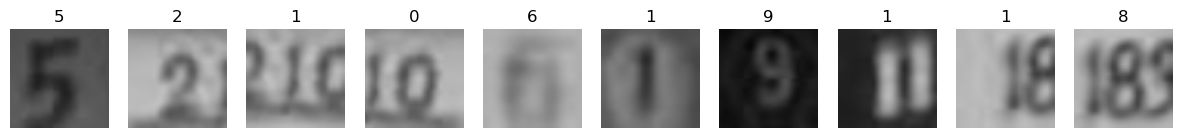

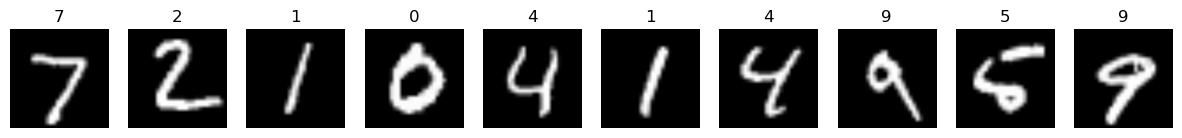

In [13]:
dataiter_svhn = iter(svhn_dataloader)
images,labels = next(dataiter_svhn)
plot_fig(images,labels)

dataiter_mnist = iter(mnist_dataloader)
images,labels = next(dataiter_mnist)
plot_fig(images,labels)

### Baseline Model

In [ ]:
model_Baseline_mnist = models.resnet50(pretrained=True)
model_Baseline_mnist.fc = torch.nn.Linear(model_Baseline_mnist.fc.in_features, 10)
model_Baseline_mnist.to(device)

model_Baseline_svhn = models.resnet50(pretrained=True)
model_Baseline_svhn.fc = torch.nn.Linear(model_Baseline_svhn.fc.in_features, 10)
model_Baseline_svhn.to(device)

In [15]:
optimizer_mnist = optim.Adam(model_Baseline_mnist.parameters(), lr=LEARNING_RATE)
optimizer_svhn = optim.Adam(model_Baseline_svhn.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

### Evaluation of CLIP

In [16]:
dataset_name = 'MNIST'
prompt = 'a vague image of the number'
val_corrects = 0
with torch.no_grad():
    
    for batch_idx, (image, target) in enumerate(tqdm.tqdm(mnist_dataloader)):
                   torch.cuda.empty_cache()
                   image = image.to(device)
            
                   text_inputs = prompt_encode(prompt).to(device)
            
                   target = target.to(device)    
            
                   logits = model_inference(model,image,text_inputs)   
            
                   _, preds = torch.max(logits,1)
            
                   val_corrects += torch.sum(preds == target.data)
          
           
    val_acc = val_corrects.double() / len(mnist)
    print(f"the zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:34<00:00,  9.01it/s]

the zero-shot performance on MNIST is 55.05%, visual encoder is ViT-B/16.


In [17]:
dataset_name = 'SVHN'
prompt = 'a vague image of the number'
val_corrects = 0
with torch.no_grad():
    
    for batch_idx, (image, target) in enumerate(tqdm.tqdm(svhn_dataloader)):
                   torch.cuda.empty_cache()
                   image = image.to(device)
            
                   text_inputs = prompt_encode(prompt).to(device)
            
                   target = target.to(device)    
            
                   logits = model_inference(model,image,text_inputs)   
            
                   _, preds = torch.max(logits,1)
            
                   val_corrects += torch.sum(preds == target.data)
          
           
    val_acc = val_corrects.double() / len(svhn)
    print(f"the zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")


100%|████████████████████████████████████████████████████████████████████████████████| 814/814 [01:46<00:00,  7.68it/s]

the zero-shot performance on SVHN is 29.91%, visual encoder is ViT-B/16.


### Evaluation of Baseline model

In [18]:

    model_Baseline_mnist.train()
    #####################Training BASELINE on MNIST##################
    
    print("start training")
    for batch_idx, (image, target) in enumerate(tqdm.tqdm(mnist_train_dataloader)):
            torch.cuda.empty_cache()
            image = image.to(device)
            
            target = target.to(device)      
            
            output = model_Baseline_mnist(image)
            
            loss = criterion(output,target)
            
            _, preds = torch.max(output, 1)
            
            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
 
            loss.backward()
            optimizer_mnist.step()
            optimizer_mnist.zero_grad()
              
            
     ###############################################################

    print('Training Completed')

start training


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [07:35<00:00,  4.12it/s]

Training Completed


In [19]:
dataset_name = 'MNIST'
torch.cuda.empty_cache()
with torch.no_grad():
    model_Baseline_mnist.eval()
    val_corrects = 0
    ##################### Testing BASELINE on MNIST ##################
    
    for batch_idx, (image, target) in enumerate(tqdm.tqdm(mnist_dataloader)):

            image = image.to(device)
            
            target = target.to(device)      
            
            output = model_Baseline_mnist(image)
            
            _, preds = torch.max(output, 1)
            

            val_corrects += torch.sum(preds == target.data)
          
           
    val_acc = val_corrects.double() / len(mnist)


     ###############################################################



    print(f"the one-shot performance on {dataset_name} is {val_acc*100:.2f}%.")

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:19<00:00, 15.96it/s]

the one-shot performance on MNIST is 97.51%.


In [20]:
    model_Baseline_svhn.train()
    #####################Training BASELINE on SVHN##################
    print("start training")
    for batch_idx, (image, target) in enumerate(tqdm.tqdm(svhn_train_dataloader)):
            torch.cuda.empty_cache()
            image = image.to(device)
            
            target = target.to(device)      
            
            output = model_Baseline_svhn(image)
            
            loss = criterion(output,target)
            
            _, preds = torch.max(output, 1)
            
            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
 
            loss.backward()
            optimizer_svhn.step()
            optimizer_svhn.zero_grad()

            
     ###############################################################


    print('Training Completed')



start training


100%|██████████████████████████████████████████████████████████████████████████████| 2290/2290 [09:25<00:00,  4.05it/s]

Training Completed


In [21]:
torch.cuda.empty_cache()
with torch.no_grad():
    model_Baseline_svhn.eval()
    val_corrects = 0
    ##################### Testing BASELINE on SVHN##################
    
    for batch_idx, (image, target) in enumerate(tqdm.tqdm(svhn_dataloader)):

            image = image.to(device)
            
            target = target.to(device)      
            
            output = model_Baseline_svhn(image)
            
            _, preds = torch.max(output, 1)
            

            val_corrects += torch.sum(preds == target.data)
          
           
    val_acc = val_corrects.double() / len(svhn)


     ###############################################################



    print(f"the one-shot performance on {dataset_name} is {val_acc*100:.2f}%.")

100%|████████████████████████████████████████████████████████████████████████████████| 814/814 [00:48<00:00, 16.77it/s]

the one-shot performance on MNIST is 88.53%.


## Scenario 2
---
zero-shot prediction on pet dogs and cats classification.

### Dataset

In [22]:
transform_Oxpet = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor()
])

Oxpet = torchvision.datasets.OxfordIIITPet(root='/shareddata', split='test',
                                       download=True,transform = transform_Oxpet)
Oxpet_dataloader = torch.utils.data.DataLoader(Oxpet, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=0)
class_names = Oxpet.classes


Oxpet_train = torchvision.datasets.OxfordIIITPet(root='/shareddata', 
                                       download=True,transform = transform_Oxpet)
Oxpet_train_dataloader = torch.utils.data.DataLoader(Oxpet_train, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=0)

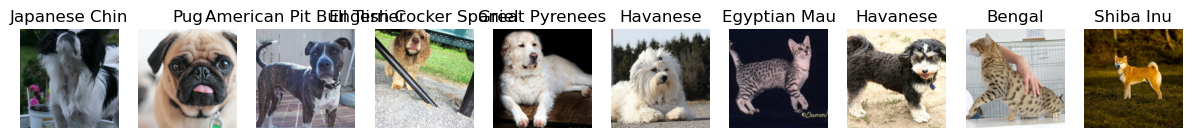

In [23]:
dataiter = iter(Oxpet_dataloader)
images,labels = next(dataiter)
plot_fig(images,labels)

### Evaluation of CLIP 

In [24]:
dataset_name = 'Oxfordpet'
with torch.no_grad():
    model.eval()
    prompt = 'an image of pet'
    torch.cuda.empty_cache()
   
    val_corrects = 0
   
    for batch_idx, (image, target) in enumerate(tqdm.tqdm(Oxpet_dataloader)):
               
        image = image.to(device)
            
        text_inputs = prompt_encode(prompt).to(device)
            
        target = target.to(device)    
            
        logits = model_inference(model,image,text_inputs)   
            
        _, preds = torch.max(logits,1)
            
        val_corrects += torch.sum(preds == target.data)
          
           
    val_acc = val_corrects.double() / len(Oxpet)
    print(f"the zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")

100%|████████████████████████████████████████████████████████████████████████████████| 115/115 [00:33<00:00,  3.43it/s]

the zero-shot performance on Oxfordpet is 86.73%, visual encoder is ViT-B/16.
